In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from collections import Counter
from lingua import LanguageDetectorBuilder, Language
from tqdm.auto import tqdm
import random
import numpy as np

/home/jovyan/conda-envs/pythonenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = open("devgpt/20231012_235128_issue_sharings.json")
data = json.loads(f.read())
f.close()

In [3]:
urls = []

In [4]:
def generate_documents(data):
    conversation_id = 0
    first_prompts = []
    first_answers = []
    chat_id = 0
    for entry in data["Sources"]:
        for sharedLink in entry["ChatgptSharing"]:
            if sharedLink.get("Conversations"):
                chat_id+=1
                conversation_id = 0
                for conversation in sharedLink["Conversations"]:
                    first_prompts.append({"chat_id" : chat_id, "round_id" : conversation_id, "prompt" : conversation["Prompt"]})
                    first_answers.append({"answer" : conversation["Answer"]})
                    urls.append({"Mentioned_URL" : sharedLink.get("Mention").get("MentionedURL")})
                    conversation_id+=1
    df = pd.DataFrame(first_prompts).join(pd.DataFrame(first_answers)).reset_index(drop=True)
    df = df.join(pd.DataFrame(urls))
    return df

In [5]:
#Detect lang https://github.com/pemistahl/lingua-py
def landetec(df):
    detector = LanguageDetectorBuilder.from_all_spoken_languages().build()
    rt_groups = []

    for name, group in df.groupby("chat_id"):
        counter = 0
        not_english_chats_ids = []
        for index, row in group.iterrows():
            lang = detector.detect_language_of(row["prompt"])
            if lang != Language.ENGLISH:
                counter+=1
    #         if row["prompt"].strip() in sample["Prompt"].tolist():
    #             counter += 1
        #some of the rounds are not in english
        if counter == 0:
            rt_groups.append(group)
    #Filter out chats that are not in english
    df_langfiltered = pd.concat(rt_groups)
    return df_langfiltered

In [6]:
df_iss = generate_documents(data)
df_iss.head(5)

,chat_id,round_id,prompt,answer,Mentioned_URL
0,1,0,Raspberry Piをアクセスポイント化させて、Wi-Fi通信をスマホとさせました。Ra...,ChatGPTRaspberry Piをアクセスポイントとして設定し、スマホとのWi-Fi通...,https://github.com/ShogoHirasawa/2023-syuron/i...
1,1,1,Raspberry Piには地図タイルが入っており、これをWi−Fi通信でスマホに配信します...,ChatGPT地図タイルを配信するためのRaspberry Piとスマホ間の接続テストを行う...,https://github.com/ShogoHirasawa/2023-syuron/i...
2,1,2,上記で教えてくれたコマンドはsshでラズパイの中に入って打つっていう認識でよいよね？,ChatGPTはい、その通りです。提供されたコマンドのほとんどは、SSH (Secure S...,https://github.com/ShogoHirasawa/2023-syuron/i...
3,2,0,iperfってどんなコマンドですか？中学生にもわかるように説明して,ChatGPT了解です！iperfは、コンピュータ間のネットワーク速度を計測するためのツール...,https://github.com/ShogoHirasawa/2023-syuron/i...
4,2,1,どういった出力結果がでる？,ChatGPTiperfを使用すると、主に以下のような情報を得ることができます：帯域幅（Ba...,https://github.com/ShogoHirasawa/2023-syuron/i...


In [7]:
len(df_iss)

2032

In [8]:
len(df_iss.groupby("chat_id"))

598

In [9]:
df_iss_langfiltered = landetec(df_iss)
df_iss_langfiltered.head(5)

,chat_id,round_id,prompt,answer,Mentioned_URL
7,3,0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea...",https://github.com/CitizensFoundation/policy-s...
8,4,0,Please analyse the text below to find the root...,ChatGPTHere is the JSON output analyzing the r...,https://github.com/CitizensFoundation/policy-s...
12,6,0,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...,https://github.com/maxoja/jampify-core/issues/69
40,8,0,"how to make pdf downloader through HTML , CSS ...","ChatGPTCreating a PDF downloader through HTML,...",https://github.com/HimankAtl/Atal/issues/2
41,9,0,How to run a java class inside of a container ...,ChatGPTTo run a Java class inside a container ...,https://github.com/jabrena/aqa-tests-experimen...


In [10]:
len(df_iss_langfiltered.groupby("chat_id"))

484

In [11]:
dropped_duplicates_df_langfiltered = df_iss_langfiltered.drop_duplicates(subset='prompt')
len(dropped_duplicates_df_langfiltered)

964

In [12]:
len(dropped_duplicates_df_langfiltered.groupby("chat_id"))

401

In [13]:
size_groups = [len(group) for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id")]

df_size = pd.DataFrame(size_groups)

In [14]:
df_size[0].unique()

array([ 1,  2,  3,  4,  9,  7,  6, 21, 12,  8,  5, 10, 20, 24, 13, 29])

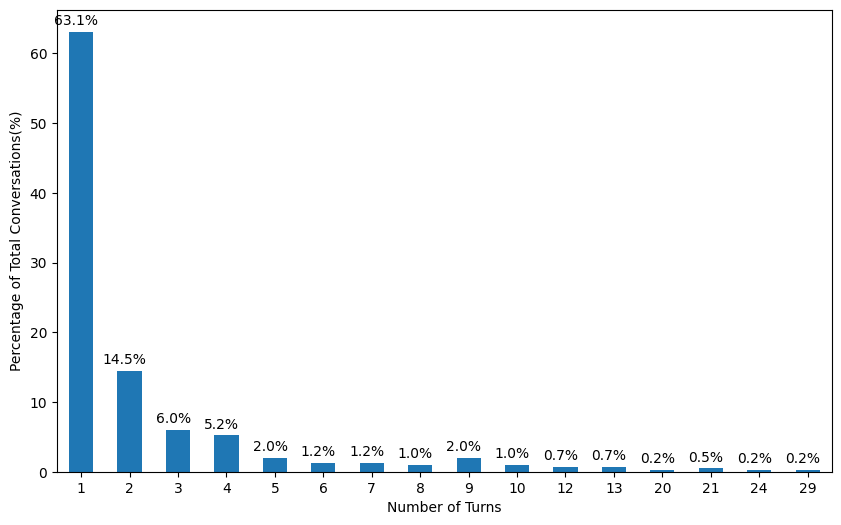

In [15]:
value_counts = df_size[0].value_counts().sort_index()
total_value = df_size[0].count()
percentage = (value_counts/total_value)*100

# Plotting the frequency distribution
plt.figure(figsize=(10, 6))
bars = percentage.plot(kind='bar')

# Annotate with percentage numbers
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1, f'{bar.get_height():.1f}%', ha='center')

#plt.title('Distribution of Prompt - Issues')
plt.xlabel('Number of Turns')
plt.ylabel('Percentage of Total Conversations(%)')
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [16]:
df_size[0].describe(percentiles=[0.25,0.5,0.80, 0.90,0.93,0.94, 0.95,0.955, 0.96, 0.97, 0.98])

count    401.000000
mean       2.403990
std        3.273589
min        1.000000
25%        1.000000
50%        1.000000
80%        3.000000
90%        5.000000
93%        7.000000
94%        8.000000
95%        9.000000
95.5%      9.000000
96%        9.000000
97%       10.000000
98%       12.000000
max       29.000000
Name: 0, dtype: float64

In [17]:
#RQ1 data
filtered_groups = [group for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id") if len(group) >= 1 and len(group) <= 8]

print(len(filtered_groups))   

378


In [18]:
first_prompts=pd.DataFrame()
for group in filtered_groups:
        first_prompt = group[group["round_id"] == 0]
        first_prompts = pd.concat([first_prompts, first_prompt])
len(first_prompts)

375

In [19]:
first_prompts.head()

,chat_id,round_id,prompt,answer,Mentioned_URL
7,3,0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea...",https://github.com/CitizensFoundation/policy-s...
8,4,0,Please analyse the text below to find the root...,ChatGPTHere is the JSON output analyzing the r...,https://github.com/CitizensFoundation/policy-s...
12,6,0,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...,https://github.com/maxoja/jampify-core/issues/69
40,8,0,"how to make pdf downloader through HTML , CSS ...","ChatGPTCreating a PDF downloader through HTML,...",https://github.com/HimankAtl/Atal/issues/2
41,9,0,How to run a java class inside of a container ...,ChatGPTTo run a Java class inside a container ...,https://github.com/jabrena/aqa-tests-experimen...


In [20]:
first_prompts_rq1 = first_prompts[['chat_id','round_id','prompt','answer']]
first_prompts_rq1.head()

,chat_id,round_id,prompt,answer
7,3,0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea..."
8,4,0,Please analyse the text below to find the root...,ChatGPTHere is the JSON output analyzing the r...
12,6,0,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...
40,8,0,"how to make pdf downloader through HTML , CSS ...","ChatGPTCreating a PDF downloader through HTML,..."
41,9,0,How to run a java class inside of a container ...,ChatGPTTo run a Java class inside a container ...


In [21]:
first_prompts_rq1.to_excel("rq1_data_issue.xlsx", index=False)
#first_prompts_rq1.to_csv("rq1_data_issue.xlsx", index=False)

In [22]:
#RQ2 data
multiturn = [group for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id") if len(group) >= 2 and len(group) <= 8]
len(multiturn)

125

In [23]:
df_multiturn = pd.concat(multiturn)
len(df_multiturn)

409

In [24]:
df_multiturn.to_excel("rq2_data_issue.xlsx", index=False)
#df_multiturn.to_csv("rq1_data_issue.xlsx", index=False)

IllegalCharacterError: Do not answer yet. This is just another part of the text I want to send you. Just receive and acknowledge as "Part 2/3 received" and wait for the next part.
[START PART 2/3]
sion dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed [8].
In this work, we use sine and cosine functions of different frequencies:
P E(pos,2i) = sin(pos/100002i/dmodel)
P E(pos,2i+1) = cos(pos/100002i/dmodel)
where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.
We also experimented with using learned positional embeddings [8] instead, and found that the two
versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered
during training.
4 Why Self-Attention
In this section we compare various aspects of self-attention layers to the recurrent and convolutional layers commonly used for mapping one variable-length sequence of symbol representations
(x1, ..., xn) to another sequence of equal length (z1, ..., zn), with xi
, zi ∈ R
d
, such as a hidden
layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we
consider three desiderata.
One is the total computational complexity per layer. Another is the amount of computation that can
be parallelized, as measured by the minimum number of sequential operations required.
The third is the path length between long-range dependencies in the network. Learning long-range
dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the
ability to learn such dependencies is the length of the paths forward and backward signals have to
traverse in the network. The shorter these paths between any combination of positions in the input
and output sequences, the easier it is to learn long-range dependencies [11]. Hence we also compare
the maximum path length between any two input and output positions in networks composed of the
different layer types.
As noted in Table 1, a self-attention layer connects all positions with a constant number of sequentially
executed operations, whereas a recurrent layer requires O(n) sequential operations. In terms of
computational complexity, self-attention layers are faster than recurrent layers when the sequence
length n is smaller than the representation dimensionality d, which is most often the case with
sentence representations used by state-of-the-art models in machine translations, such as word-piece
[31] and byte-pair [25] representations. To improve computational performance for tasks involving
very long sequences, self-attention could be restricted to considering only a neighborhood of size r in
6
the input sequence centered around the respective output position. This would increase the maximum
path length to O(n/r). We plan to investigate this approach further in future work.
A single convolutional layer with kernel width k < n does not connect all pairs of input and output
positions. Doing so requires a stack of O(n/k) convolutional layers in the case of contiguous kernels,
or O(logk(n)) in the case of dilated convolutions [15], increasing the length of the longest paths
between any two positions in the network. Convolutional layers are generally more expensive than
recurrent layers, by a factor of k. Separable convolutions [6], however, decrease the complexity
considerably, to O(k · n · d + n · d
2
). Even with k = n, however, the complexity of a separable
convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer,
the approach we take in our model.
As side benefit, self-attention could yield more interpretable models. We inspect attention distributions
from our models and present and discuss examples in the appendix. Not only do individual attention
heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic
and semantic structure of the sentences.
5 Training
This section describes the training regime for our models.
5.1 Training Data and Batching
We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million
sentence pairs. Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT
2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece
vocabulary [31]. Sentence pairs were batched together by approximate sequence length. Each training
batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000
target tokens.
5.2 Hardware and Schedule
We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using
the hyperparameters described throughout the paper, each training step took about 0.4 seconds. We
trained the base models for a total of 100,000 steps or 12 hours. For our big models,(described on the
bottom line of table 3), step time was 1.0 seconds. The big models were trained for 300,000 steps
(3.5 days).
5.3 Optimizer
We used the Adam optimizer [17] with β1 = 0.9, β2 = 0.98 and  = 10−9
. We varied the learning
rate over the course of training, according to the formula:
lrate = d
−0.5
model · min(step_num−0.5
, step_num · warmup_steps−1.5
) (3)
This corresponds to increasing the learning rate linearly for the first warmup_steps training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number. We used
warmup_steps = 4000.
5.4 Regularization
We employ three types of regularization during training:
Residual Dropout We apply dropout [27] to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of
Pdrop = 0.1.
7
Table 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the
English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.
Model
BLEU Training Cost (FLOPs)
EN-DE EN-FR EN-DE EN-FR
ByteNet [15] 23.75
Deep-Att + PosUnk [32] 39.2 1.0 · 1020
GNMT + RL [31] 24.6 39.92 2.3 · 1019 1.4 · 1020
ConvS2S [8] 25.16 40.46 9.6 · 1018 1.5 · 1020
MoE [26] 26.03 40.56 2.0 · 1019 1.2 · 1020
Deep-Att + PosUnk Ensemble [32] 40.4 8.0 · 1020
GNMT + RL Ensemble [31] 26.30 41.16 1.8 · 1020 1.1 · 1021
ConvS2S Ensemble [8] 26.36 41.29 7.7 · 1019 1.2 · 1021
Transformer (base model) 27.3 38.1 3.3 · 1018
Transformer (big) 28.4 41.0 2.3 · 1019
Label Smoothing During training, we employed label smoothing of value ls = 0.1 [30]. This
hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.
6 Results
6.1 Machine Translation
On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.
On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.
For the base models, we used a single model obtained by averaging the last 5 checkpoints, which
were written at 10-minute intervals. For the big models, we averaged the last 20 checkpoints. We
used beam search with a beam size of 4 and length penalty α = 0.6 [31]. These hyperparameters
were chosen after experimentation on the development set. We set the maximum output length during
inference to input length + 50, but terminate early when possible [31].
Table 2 summarizes our results and compares our translation quality and training costs to other model
architectures from the literature. We estimate the number of floating point operations used to train a
model by multiplying the training time, the number of GPUs used, and an estimate of the sustained
single-precision floating-point capacity of each GPU 5
.
6.2 Model Variations
To evaluate the importance of different components of the Transformer, we varied our base model
in different ways, measuring the change in performance on English-to-German translation on the
development set, newstest2013. We used beam search as described in the previous section, but no
checkpoint averaging. We present these results in Table 3.
In Table 3 rows (A), we vary the number of attention heads and the attention key and value dimensions,
keeping the amount of computation constant, as described in Section 3.2.2. While single-head
attention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.
5We used values of 2.8, 3.7, 6.0 and 9.5 TFLOPS for K80, K40, M40 and P100, respectively.
8
Table 3: Variations on the Transformer architecture. Unlisted values are identical to those of the base
model. All metrics are on the English-to-German translation development set, newstest2013. Listed
perplexities are per-wordpiece, according to our byte-pair encoding, and should not be compared to
per-word perplexities.
N dmodel dff h dk dv Pdrop ls
train PPL BLEU params
steps (dev) (dev) ×106
base 6 512 2048 8 64 64 0.1 0.1 100K 4.92 25.8 65
(A)
1 512 512 5.29 24.9
4 128 128 5.00 25.5
16 32 32 4.91 25.8
32 16 16 5.01 25.4
(B) 16 5.16 25.1 58
32 5.01 25.4 60
(C)
2 6.11 23.7 36
4 5.19 25.3 50
8 4.88 25.5 80
256 32 32 5.75 24.5 28
1024 128 128 4.66 26.0 168
1024 5.12 25.4 53
4096 4.75 26.2 90
(D)
0.0 5.77 24.6
0.2 4.95 25.5
0.0 4.67 25.3
0.2 5.47 25.7
(E) positional embedding instead of sinusoids 4.92 25.7
big 6 1024 4096 16 0.3 300K 4.33 26.4 213
In Table 3 rows (B), we observe that reducing the attention key size dk hurts model quality. This
suggests that determining compatibility is not easy and that a more sophisticated compatibility
function than dot product may be beneficial. We further observe in rows (C) and (D) that, as expected,
bigger models are better, and dropout is very helpful in avoiding over-fitting. In row (E) we replace our
sinusoidal positional encoding with learned positional embeddings [8], and observe nearly identical
results to the base model.
7 Conclusion
In this work, we presented the Transformer, the first sequence transduction model based entirely on
attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with
multi-headed self-attention.
For translation tasks, the Transformer can be trained significantly faster than architectures based
on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014
English-to-French translation tasks, we achieve a new state of the art. In the former task our best
model outperforms even all previously reported ensembles.
We are excited about the future of attention-based models and plan to apply them to other tasks. We
plan to extend the Transformer to problems involving input and output modalities other than text and
to investigate local, restricted attention mechanisms to efficiently handle large inputs and outputs
such as images, audio and video. Making generation less sequential is another research goals of ours.
The code we used to train and evaluate our models is available at https://github.com/
tensorflow/tensor2tensor.
Acknowledgements We are grateful to Nal Kalchbrenner and Stephan Gouws for their fruitful
comments, corrections and inspiration.
9
References
[1] Jimmy Lei Ba, Jamie Ryan Kiros, and Geoffrey E Hinton. Layer normalization. arXiv preprint
arXiv:1607.06450, 2016.
[2] Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. Neural machine translation by jointly
learning to align and translate. CoRR, abs/1409.0473, 2014.
[3] Denny Britz, Anna Goldie, Minh-Thang Luong, and Quoc V. Le. Massive exploration of neural
machine translation architectures. CoRR, abs/1703.03906, 2017.
[4] Jianpeng Cheng, Li Dong, and Mirella Lapata. Long short-term memory-networks for machine
reading. arXiv preprint arXiv:1601.06733, 2016.
[5] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk,
and Yoshua Bengio. Learning phrase representations using rnn encoder-decoder for statistical
machine translation. CoRR, abs/1406.1078, 2014.
[6] Francois Chollet. Xception: Deep learning with depthwise separable convolutions. arXiv
preprint arXiv:1610.02357, 2016.
[7] Junyoung Chung, Çaglar Gülçehre, Kyunghyun Cho, and Yoshua Bengio. Empirical evaluation
of gated recurrent neural networks on sequence modeling. CoRR, abs/1412.3555, 2014.
[8] Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolutional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.
[9] Alex Graves. Generating sequences with recurrent neural networks. arXiv preprint
arXiv:1308.0850, 2013.
[10] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition, pages 770–778, 2016.
[11] Sepp Hochreiter, Yoshua Bengio, Paolo Frasconi, and Jürgen Schmidhuber. Gradient flow in
recurrent nets: the difficulty of learning long-term dependencies, 2001.
[12] Sepp Hochreiter and Jürgen Schmidhuber. Long short-term memory. Neural computation,
9(8):1735–1780, 1997.
[13] Rafal Jozefowicz, Oriol Vinyals, Mike Schuster, Noam Shazeer, and Yonghui Wu. Exploring
the limits of language modeling. arXiv preprint arXiv:1602.02410, 2016.
[14] Łukasz Kaiser and Ilya Sutskever. Neural GPUs learn algorithms. In International Conference
on Learning Representations (ICLR), 2016.
[15] Nal Kalchbrenner, Lasse Espeholt, Karen Simonyan, Aaron van den Oord, Alex Graves, and Koray Kavukcuoglu. Neural machine translation in linear time. arXiv preprint arXiv:1610.10099v2,
2017.
[16] Yoon Kim, Carl Denton, Luong Hoang, and Alexander M. Rush. Structured attention networks.
In International Conference on Learning Representations, 2017.
[17] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICLR, 2015.
[18] Oleksi
[END PART 2/3]
Remember not answering yet. Just acknowledge you received this part with the message "Part 2/3 received" and wait for the next part. cannot be used in worksheets.

In [26]:
#RQ3 data
df_rq1_iss = pd.read_excel('rq1_data_issue.xlsx')
df_rq1_iss 

,chat_id,Category,prompt,answer,type
0,150,Code generation,Is there a way to write exif data to a jpg usi...,"ChatGPTYes, you can manipulate EXIF data in a ...",issue
1,38,Code generation,Make this Java code into Android Java code so ...,ChatGPTTo convert the provided Java code into ...,issue
2,247,Code generation,Given this issue https://github.com/openrewrit...,"ChatGPTAs an AI language model, I can provide ...",issue
3,193,Data generation,I need help finding a name for a website that ...,ChatGPTLingaNetLexaLinkVocaVerseTalkTroveWordW...,issue
4,527,Code generation,Write a GitHub Actions workflow implementing t...,ChatGPTCertainly! Here's a GitHub Actions work...,issue
...,...,...,...,...,...
365,529,Code generation,This is my code\n\n # -- Define custom coll...,ChatGPTTo modify your custom_collate_fn to mas...,issue
366,550,Others,what compounds may treat Alternating Hemiplegi...,ChatGPTAlternating Hemiplegia of Childhood (AH...,issue
367,552,Data generation,Give me a list of 100 compounds (molecules) th...,"ChatGPTAs an AI language model, I can provide ...",issue
368,578,How-to,How do I fix this python error: No module name...,"ChatGPTThe error message ""No module named 'bs4...",issue


In [27]:
df_rq1_iss['Mentioned_URL'] = ''
for index, row in df_rq1_iss.iterrows():
    chat_id = row['chat_id']
    matching_url = first_prompts.loc[first_prompts['chat_id'] == chat_id, 'Mentioned_URL']
    df_rq1_iss.at[index, 'Mentioned_URL'] = matching_url.iloc[0]
    
df_rq1_iss

,chat_id,Category,prompt,answer,type,Mentioned_URL
0,150,Code generation,Is there a way to write exif data to a jpg usi...,"ChatGPTYes, you can manipulate EXIF data in a ...",issue,https://github.com/moom0o/PhotoSphereStudio/is...
1,38,Code generation,Make this Java code into Android Java code so ...,ChatGPTTo convert the provided Java code into ...,issue,https://github.com/rane254/RPSAndroidGame/issu...
2,247,Code generation,Given this issue https://github.com/openrewrit...,"ChatGPTAs an AI language model, I can provide ...",issue,https://github.com/openrewrite/rewrite-spring/...
3,193,Data generation,I need help finding a name for a website that ...,ChatGPTLingaNetLexaLinkVocaVerseTalkTroveWordW...,issue,https://github.com/sillsdev/languageforge-lexb...
4,527,Code generation,Write a GitHub Actions workflow implementing t...,ChatGPTCertainly! Here's a GitHub Actions work...,issue,https://github.com/simonw/simonw-readthedocs-e...
...,...,...,...,...,...,...
365,529,Code generation,This is my code\n\n # -- Define custom coll...,ChatGPTTo modify your custom_collate_fn to mas...,issue,https://github.com/huggingface/transformers/is...
366,550,Others,what compounds may treat Alternating Hemiplegi...,ChatGPTAlternating Hemiplegia of Childhood (AH...,issue,https://github.com/NCATSTranslator/Feedback/is...
367,552,Data generation,Give me a list of 100 compounds (molecules) th...,"ChatGPTAs an AI language model, I can provide ...",issue,https://github.com/NCATSTranslator/Feedback/is...
368,578,How-to,How do I fix this python error: No module name...,"ChatGPTThe error message ""No module named 'bs4...",issue,https://github.com/jasonacox/Powerwall-Dashboa...


In [30]:
len(df_rq1_iss['Mentioned_URL'])

370

In [48]:
from sklearn.model_selection import train_test_split
issues_sample = df_rq1_iss.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
len(issues_sample)

370

In [49]:
issues_class_proportions = df_rq1_iss['Category'].value_counts(normalize=True)

num_samples_issue = 167

issues_sampled = pd.DataFrame()

In [50]:
for label, proportion in issues_class_proportions.items():
    # Calculate the number of samples for this class
    num_samples = int(num_samples_issue * proportion)
    
    # Sample from the original dataset
    samples = df_rq1_iss[df_rq1_iss['Category'] == label].sample(n=num_samples, random_state=42)
    
    # Append to the sampled dataset
    issues_sampled = pd.concat([issues_sampled, samples])

print(len(issues_sampled))

161


In [51]:
#need 160 data only
issues_sampled.drop(issues_sampled.index[-1], inplace=True)


In [52]:
len(issues_sampled)

160

In [54]:
issues_sample_file_path = 'rq3_issues_sample.xlsx'

issues_sampled.to_excel(issues_sample_file_path, index=False)